In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm
import os
from scipy import stats


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_dir = 'res_svm_prev'
should_savefig = False

In [36]:
def convert(df_res, col):
    stocks_ = []
    for i, row in df_res.iterrows():
        s = row[col]
        if isinstance(s, int) or isinstance(s, np.float64) or isinstance(s, float):
            stocks_.append(s)
        elif isinstance(s, dict):
            stocks_.append(list(s.values())[0])
        else: 
            try:
                s = literal_eval(s)
                if isinstance(s, dict):
                    stocks_.append(list(s.values())[0])
                else:
                    stocks_.append(float(s))
            except Exception as e:
                print(col, s, e)
                stocks_.append(s)
    return stocks_

In [39]:
results_files = os.listdir(data_dir)
df_res = pd.DataFrame()
for f in results_files:
    if 'csv' not in f:
        continue
    df_res = df_res.append(pd.read_csv(os.path.join(data_dir, f)))

df_res.drop(columns=['Unnamed: 0'], inplace=True)

print(df_res.columns)
for c in df_res.columns:
    if c in ['kernel', 'features', 'coef0']:
        continue
    df_res[c] = convert(df_res, c)
df_res.head()

Index(['C', 'Unnamed: 0.1', 'coef0', 'f1', 'features', 'gamma', 'kappa',
       'kernel', 'matthews', 'precision', 'recall', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_precision',
       'test_recall', 'test_roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc',
       'train_val_f1', 'train_val_kappa', 'train_val_matthews',
       'train_val_precision', 'train_val_recall', 'train_val_roc_auc'],
      dtype='object')


,C,Unnamed: 0.1,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
0,0.001,NaN,NaN,0.088323,que_prev,0.001,0.0,rbf,0.0,0.056676,...,0.000000,0.000000,0.000000,0.500000,0.093402,0.0,0.0,0.060928,0.2,0.5
1,0.001,NaN,NaN,0.088323,que_prev,0.010,0.0,rbf,0.0,0.056676,...,0.000000,0.000000,0.000000,0.500000,0.093402,0.0,0.0,0.060928,0.2,0.5
2,0.001,NaN,NaN,0.088323,que_prev,0.100,0.0,rbf,0.0,0.056676,...,0.000000,0.000000,0.000000,0.500000,0.093402,0.0,0.0,0.060928,0.2,0.5
3,0.001,NaN,NaN,0.088323,que_prev,1.000,0.0,rbf,0.0,0.056676,...,0.123098,0.361484,0.516288,0.566613,0.093402,0.0,0.0,0.060928,0.2,0.5
4,0.001,NaN,NaN,0.088323,que_prev,10.000,0.0,rbf,0.0,0.056676,...,0.000000,0.000000,0.000000,0.500000,0.093402,0.0,0.0,0.060928,0.2,0.5


In [40]:
df_best_rbf = df_res[df_res['kernel'] == 'rbf'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_lin = df_res[df_res['kernel'] == 'linear'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_sig = df_res[df_res['kernel'] == 'sigmoid'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)

In [41]:
df_best = df_res.sort_values(by=['matthews', 'train_matthews'], ascending=False).groupby('stock').head(1)

## Distributions

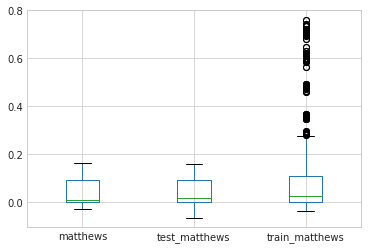

In [42]:
df_res[['matthews', 'test_matthews', 'train_matthews']].boxplot()

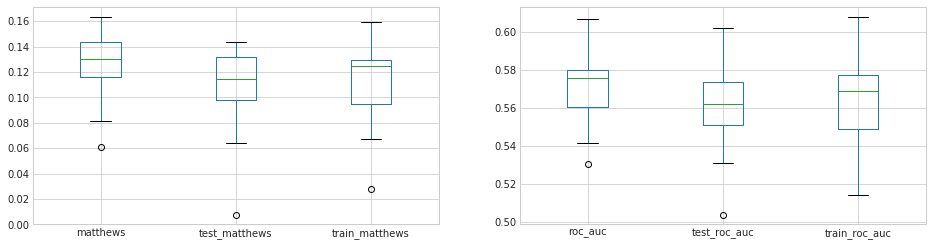

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_best[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)

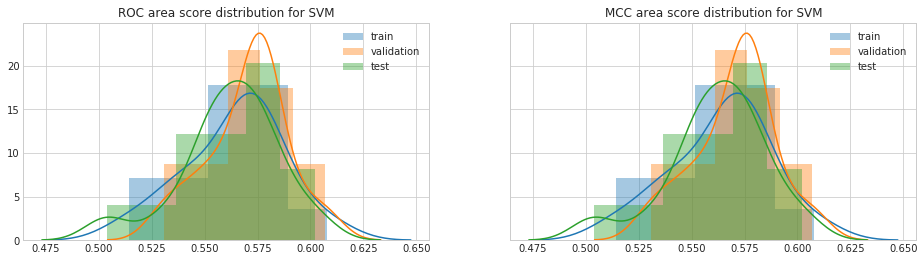

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM')

sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('MCC area score distribution for SVM')

ax1.legend()
ax2.legend()

### Per kernel

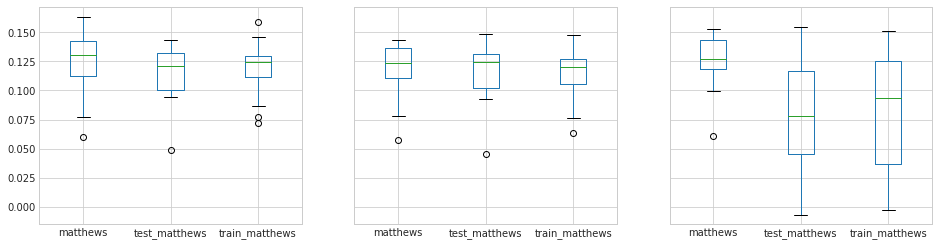

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
df_best_rbf[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_best_lin[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax2)
df_best_sig[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax3)

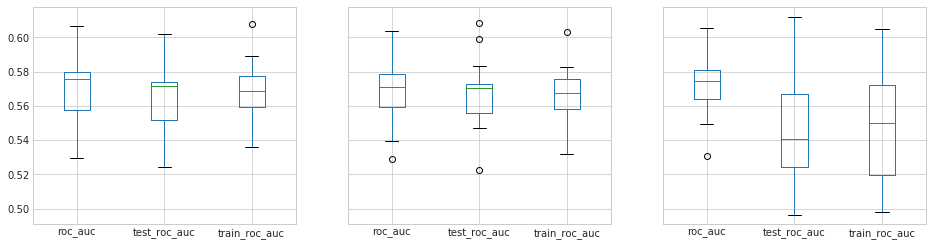

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
df_best_rbf[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax1)
df_best_lin[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)
df_best_sig[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax3)

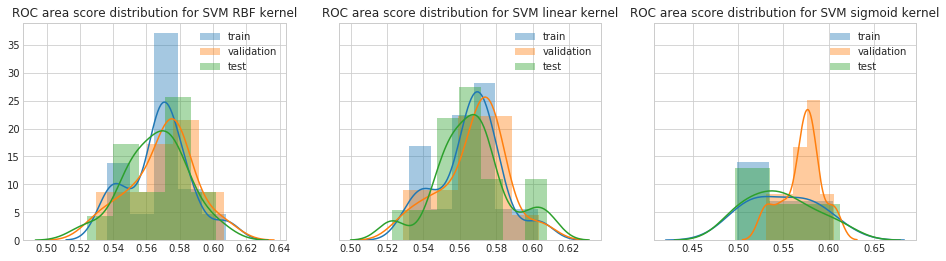

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.distplot(df_best_rbf[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best_lin[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('ROC area score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_roc_auc']], label='train', ax=ax3)
sns.distplot(df_best_sig[['roc_auc']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_roc_auc']], label='test', ax=ax3)
ax3.set_title('ROC area score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

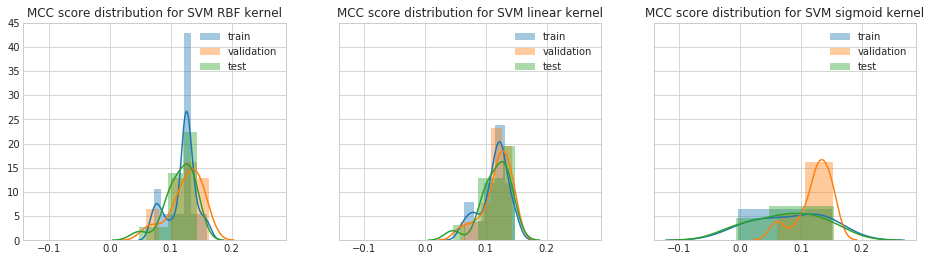

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=True)
sns.distplot(df_best_rbf[['train_matthews']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['matthews']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_matthews']], label='test', ax=ax1)
ax1.set_title('MCC score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_matthews']], label='train', ax=ax2)
sns.distplot(df_best_lin[['matthews']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_matthews']], label='test', ax=ax2)
ax2.set_title('MCC score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_matthews']], label='train', ax=ax3)
sns.distplot(df_best_sig[['matthews']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_matthews']], label='test', ax=ax3)
ax3.set_title('MCC score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

### Distributions without sigmoid

In [50]:
df_ker = df_res[df_res['kernel'] != 'sigmoid']
df_ker = df_ker.sort_values(by='matthews', ascending=False).groupby('stock').head(1)

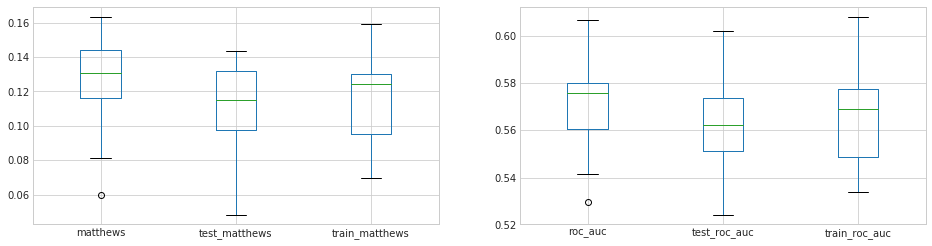

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_ker[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_ker[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)

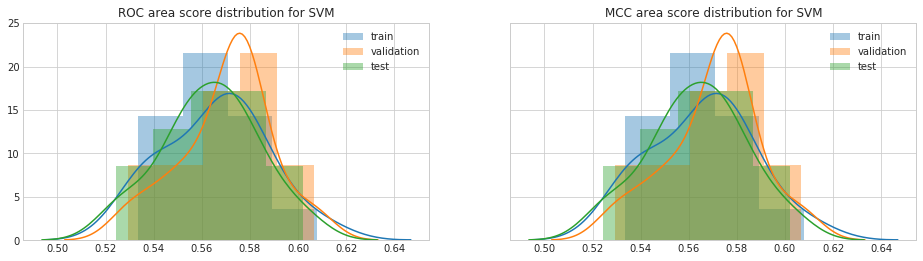

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.distplot(df_ker[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_ker[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_ker[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM')

sns.distplot(df_ker[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_ker[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_ker[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('MCC area score distribution for SVM')

ax1.legend()
ax2.legend()

## Compare with QUE+LOG

In [53]:
df_log = pd.read_csv('res_log_que.csv')
df_log.head()

,Unnamed: 0,class_weights,f1,kappa,kernel,matthews,precision,recall,roc_auc,stock,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
0,9269,"{0.0: 0.836091273297335, 1.0: 1.2438455558434827}",0.510800,0.093214,logistic,0.100470,0.435052,0.627165,0.550638,9269,...,0.094565,0.448586,0.555066,0.548218,0.507599,0.086723,0.089307,0.449844,0.582545,0.545330
1,3022,"{0.0: 0.7298160255435608, 1.0: 1.587826662256037}",0.440221,0.102841,logistic,0.113407,0.357526,0.581350,0.560990,3022,...,0.115502,0.368437,0.586173,0.562168,0.451454,0.099532,0.107777,0.366223,0.588595,0.557860
2,2051,"{0.0: 0.5945376850188889, 1.0: 3.144448083851949}",0.308374,0.096571,logistic,0.118968,0.213634,0.558961,0.579171,2051,...,0.122543,0.208199,0.593842,0.583414,0.304148,0.097964,0.123845,0.206687,0.575964,0.584607
3,3879,"{0.0: 0.7008834051252099, 1.0: 1.7445029983645...",0.428990,0.124127,logistic,0.137354,0.337460,0.591021,0.576551,3879,...,0.136157,0.350998,0.584954,0.575203,0.448760,0.126081,0.139540,0.354127,0.613801,0.576524
4,10166,"{0.0: 0.8430666549574076, 1.0: 1.2287213618328...",0.512189,0.119137,logistic,0.120872,0.470075,0.563449,0.561400,10166,...,0.108777,0.460605,0.563420,0.555355,0.504377,0.102871,0.104679,0.458109,0.561199,0.553257


In [54]:
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['', '_log'])
df_best.head()

,C,Unnamed: 0.1,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,train_matthews_log,train_precision_log,train_recall_log,train_roc_auc_log,train_val_f1_log,train_val_kappa_log,train_val_matthews_log,train_val_precision_log,train_val_recall_log,train_val_roc_auc_log
0,1000.0,NaN,NaN,0.270388,que_prev,0.010,0.142796,rbf,0.163370,0.280159,...,0.105855,0.184566,0.580131,0.575097,0.256466,0.082278,0.101212,0.177427,0.484862,0.569234
1,1.0,NaN,NaN,0.412504,que_prev,0.100,0.149487,rbf,0.154382,0.382853,...,0.125276,0.355845,0.572359,0.568539,0.421187,0.118964,0.125167,0.351395,0.528212,0.568139
2,1000.0,NaN,NaN,0.295478,que_prev,0.100,0.114590,rbf,0.149780,0.196501,...,0.146122,0.208106,0.611383,0.601755,0.319661,0.114920,0.151100,0.213468,0.639043,0.603678
3,100.0,38.0,{38: nan},0.399203,{38: 'que_prev'},1.000,0.135157,{38: 'rbf'},0.144797,0.326664,...,0.129243,0.310112,0.596408,0.574360,0.398935,0.112480,0.126299,0.305230,0.576342,0.572930
4,100.0,NaN,NaN,0.425352,que_prev,0.001,0.131432,rbf,0.143031,0.338206,...,0.123718,0.336310,0.572098,0.568951,0.430402,0.111052,0.122741,0.338093,0.592867,0.568086


In [55]:
df_best_lin = pd.merge(df_best_lin, df_log, on='stock', suffixes=['', '_log'])
df_best_rbf = pd.merge(df_best_rbf, df_log, on='stock', suffixes=['', '_log'])
df_best_sig = pd.merge(df_best_sig, df_log, on='stock', suffixes=['', '_log'])

In [59]:
df_best['diff_test_matthews'] = df_best['test_matthews'] - df_best['test_matthews_log']
df_best['diff_test_matthews'].describe()

count    15.000000
mean     -0.006331
std       0.021175
min      -0.069208
25%      -0.005073
50%       0.002122
75%       0.004903
max       0.007301
Name: diff_test_matthews, dtype: float64

### Regular comparision of scores

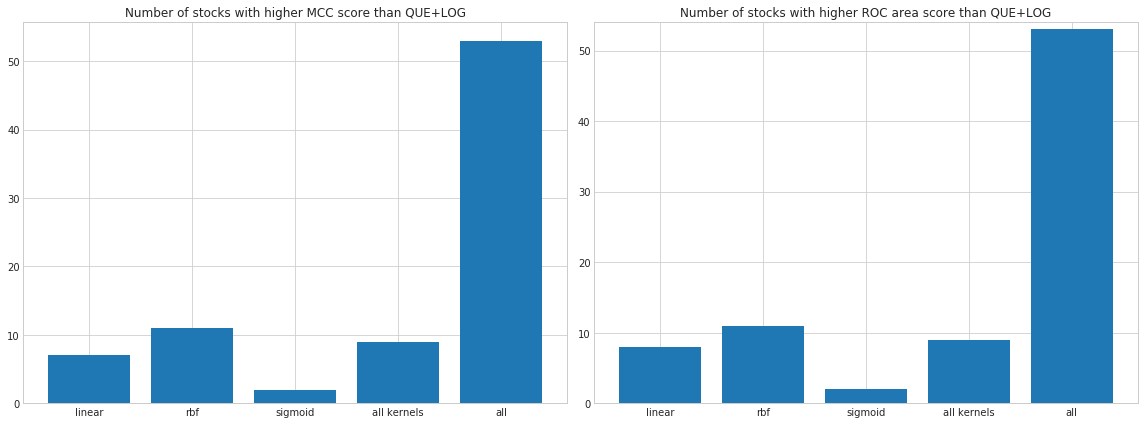

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

lin = len(df_best_lin[df_best_lin['test_matthews'] > df_best_lin['test_matthews_log']])
rbf = len(df_best_rbf[df_best_rbf['test_matthews'] > df_best_rbf['test_matthews_log']])
sig = len(df_best_sig[df_best_sig['test_matthews'] > df_best_sig['test_matthews_log']])
b = len(df_best[df_best['test_matthews'] > df_best['test_matthews_log']])
ax1.bar(['linear', 'rbf', 'sigmoid', 'all kernels', 'all'], [lin, rbf, sig, b, 53])
ax1.set_title('Number of stocks with higher MCC score than QUE+LOG')

lin = len(df_best_lin[df_best_lin['test_roc_auc'] > df_best_lin['test_roc_auc_log']])
rbf = len(df_best_rbf[df_best_rbf['test_roc_auc'] > df_best_rbf['test_roc_auc_log']])
sig = len(df_best_sig[df_best_sig['test_roc_auc'] > df_best_sig['test_roc_auc_log']])
b = len(df_best[df_best['test_roc_auc'] > df_best['test_roc_auc_log']])
ax2.bar(['linear', 'rbf', 'sigmoid', 'all kernels', 'all'], [lin, rbf, sig, b, 53])
ax2.set_title('Number of stocks with higher ROC area score than QUE+LOG')
plt.ylim(0, 54)
plt.ylim(0, 54)
plt.tight_layout()